## ADA501 - Prosjekt

In [1]:
# !pip install numpy_financial

In [2]:
import pandas as pd
import numpy as np
import sympy as sp
from collections import namedtuple
from scipy.integrate import quad
from scipy.optimize import newton
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import numpy_financial as npf
import matplotlib.pyplot as plt
from collections import namedtuple
from scipy.integrate import odeint

## les inn csv filer

In [3]:
df = pd.read_excel('Siste.xlsx')
df_rente_kpi = pd.read_excel('siste_rente_kpi.xlsx')
bnp = pd.read_excel('BNP.xlsx')
kpi_jae = pd.read_excel('kpijae.xlsx')

In [4]:
# Replace 'M' with '-' in the 'Dato' column
kpi_jae['Dato'] = kpi_jae['Dato'].str.replace('M', '-')

# Convert 'Dato' to datetime format
kpi_jae['Dato'] = pd.to_datetime(kpi_jae['Dato'], format='%Y-%d')

kpi_jae['prosent change'] = kpi_jae['KPI-JAE Totalindeks'].pct_change(1)

Oppdeling av filen i df

In [5]:
# Filter 'Inntekt'
inntekt = df[df['Hva'] == 'Inntekt']
inntekt = inntekt.drop('Hva', axis=1)
# Filter 'Faste utgifter'
faste_utgifter = df[df['Hva'] == 'Fast utgift']
faste_utgifter = faste_utgifter.drop('Hva', axis=1)
# Filter 'Luksus'
forbruk = df[df['Hva'] == 'Luksus']
forbruk=forbruk.drop('Hva' , axis=1)
# Filter 'Rente'
rente = df_rente_kpi[['Dato', 'Rente']]
# Filter 'styringsrente'
kpi = df_rente_kpi[['Dato' , 'Konsumprisindeks(2015=100)', 'Månedsendring (prosent)']]

## Regressionsmodeller

Inntekt, Faste utgifter, forbruk, rente & styringsrente

Inntekt

In [6]:
# Dato til pd_datetime & float
inntekt['Brukt'] = inntekt['Brukt'].str.replace(',', '.')
inntekt['Brukt'] = inntekt['Brukt'].astype(float)
inntekt['Dato'] = pd.to_datetime(inntekt['Dato'])

Gjør om til måendlig

In [7]:
# Grouping the data by year and month and calculating the sum of 'Brukt' for each group
Monthly_income = inntekt.groupby(inntekt['Dato'].dt.to_period('M')).sum()

# Resetting the index to access the 'Dato' column
Monthly_income = Monthly_income.reset_index()

# Renaming the 'Dato' column to match the desired format 'YYYY-MM'
Monthly_income['Dato'] = Monthly_income['Dato'].dt.strftime('%Y-%m')

# Creating a new DataFrame named 'Monthly_income'
inntekt_måendlig = pd.DataFrame({'Dato': Monthly_income['Dato'], 'Income': Monthly_income['Brukt']})

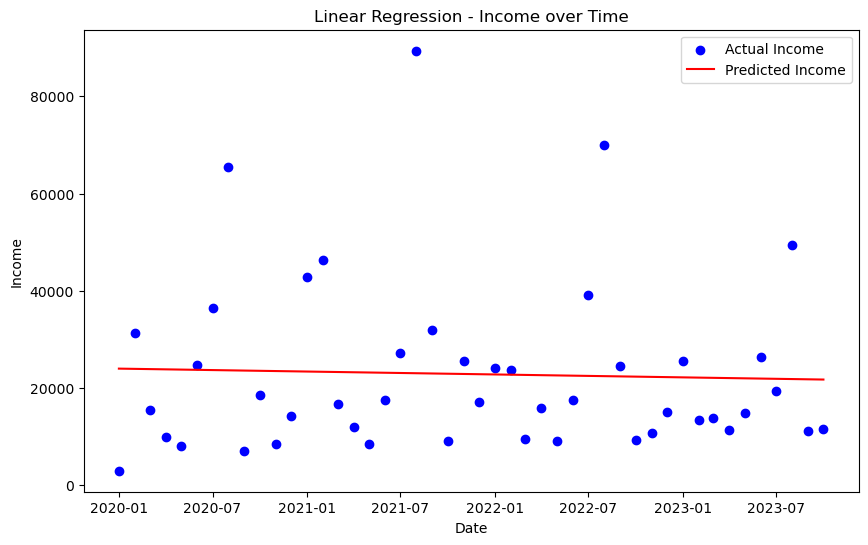

In [8]:
# Assuming you have your data stored in måendlig_inntekt DataFrame as described previously

# Convert 'Dato' column to datetime if it's in string format
inntekt_måendlig['Dato'] = pd.to_datetime(inntekt_måendlig['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
inntekt_måendlig['Dato_numeric'] = (inntekt_måendlig['Dato'] - inntekt_måendlig['Dato'].min()).dt.days

# Define features and target variable
X_inntekt = inntekt_måendlig[['Dato_numeric']]
y_inntekt = inntekt_måendlig['Income']

# Initialize Linear Regression model
model_inntekt = LinearRegression()

# Fit the model
model_inntekt.fit(X_inntekt, y_inntekt)

# Make predictions
predictions_inntekt = model_inntekt.predict(X_inntekt)

# Visualize the linear regression line and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(inntekt_måendlig['Dato'], y_inntekt, color='blue', label='Actual Income')

# Plotting the regression line
plt.plot(inntekt_måendlig['Dato'], predictions_inntekt, color='red', label='Predicted Income')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Income')
plt.title('Linear Regression - Income over Time')
plt.legend()
plt.show()


Faste utgifter

In [9]:
# Dato til pd_datetime & float
faste_utgifter['Brukt'] = faste_utgifter['Brukt'].str.replace(',', '.')
faste_utgifter['Brukt'] = faste_utgifter['Brukt'].astype(float)
faste_utgifter['Dato'] = pd.to_datetime(faste_utgifter['Dato'])

In [10]:
# Grouping the data by year and month and calculating the sum of 'Brukt' for each group
Monthly_out = faste_utgifter.groupby(faste_utgifter['Dato'].dt.to_period('M')).sum()

# Resetting the index to access the 'Dato' column
Monthly_out = Monthly_out.reset_index()

# Renaming the 'Dato' column to match the desired format 'YYYY-MM'
Monthly_out['Dato'] = Monthly_out['Dato'].dt.strftime('%Y-%m')

# Creating a new DataFrame named 'Monthly_income'
utgift_måendlig = pd.DataFrame({'Dato': Monthly_out['Dato'], 'Faste utgifter': Monthly_out['Brukt']})

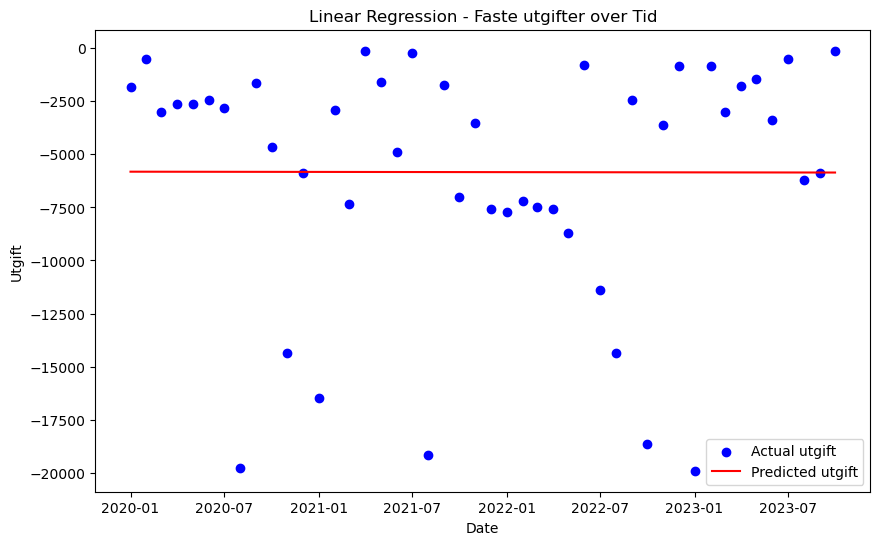

In [11]:
# Convert 'Dato' column to datetime if it's in string format
utgift_måendlig['Dato'] = pd.to_datetime(utgift_måendlig['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
utgift_måendlig['Dato_numeric'] = (utgift_måendlig['Dato'] - utgift_måendlig['Dato'].min()).dt.days

# Define features and target variable
X_utgift = utgift_måendlig[['Dato_numeric']]
y_utgift = utgift_måendlig['Faste utgifter']

# Initialize Linear Regression model
model_utgift = LinearRegression()

# Fit the model
model_utgift.fit(X_utgift, y_utgift)

# Make predictions
predictions_utgift = model_utgift.predict(X_utgift)

# Visualize the linear regression line and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(utgift_måendlig['Dato'], y_utgift, color='blue', label='Actual utgift')

# Plotting the regression line
plt.plot(utgift_måendlig['Dato'], predictions_utgift, color='red', label='Predicted utgift')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Utgift')
plt.title('Linear Regression - Faste utgifter over Tid')
plt.legend()
plt.show()

Har faste utgifter på 5750 kr i husleie nå + 4000 kr i mat, trening & mobil

Fast = 10 000 kr pr måend

Forbruk

In [12]:
# Dato til pd_datetime & float
forbruk['Brukt'] = forbruk['Brukt'].str.replace(',', '.')
forbruk['Brukt'] = forbruk['Brukt'].astype(float)
forbruk['Dato'] = pd.to_datetime(forbruk['Dato'])

In [13]:
# Grouping the data by year and month and calculating the sum of 'Brukt' for each group
Monthly_forbruk = forbruk.groupby(forbruk['Dato'].dt.to_period('M')).sum()

# Resetting the index to access the 'Dato' column
Monthly_forbruk = Monthly_forbruk.reset_index()

# Renaming the 'Dato' column to match the desired format 'YYYY-MM'
Monthly_forbruk['Dato'] = Monthly_forbruk['Dato'].dt.strftime('%Y-%m')

# Creating a new DataFrame named 'Monthly_income'
forbruk_måendlig = pd.DataFrame({'Dato': Monthly_forbruk['Dato'], 'Forbruk': Monthly_forbruk['Brukt']})

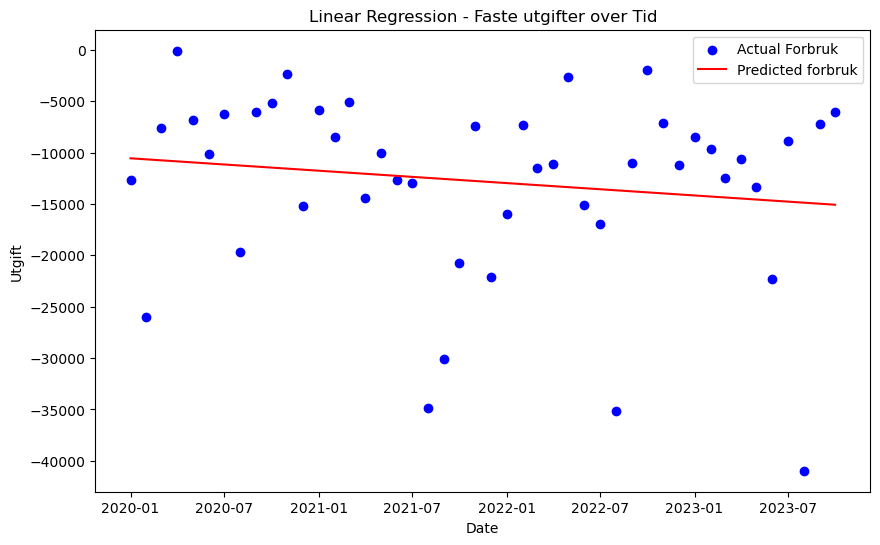

In [14]:
# Convert 'Dato' column to datetime if it's in string format
forbruk_måendlig['Dato'] = pd.to_datetime(forbruk_måendlig['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
forbruk_måendlig['Dato_numeric'] = (forbruk_måendlig['Dato'] - forbruk_måendlig['Dato'].min()).dt.days

# Define features and target variable
X_forbruk = forbruk_måendlig[['Dato_numeric']]
y_forbruk = forbruk_måendlig['Forbruk']

# Initialize Linear Regression model
model_forbruk = LinearRegression()

# Fit the model
model_forbruk.fit(X_forbruk, y_forbruk)

# Make predictions
predictions_forbruk = model_forbruk.predict(X_forbruk)

# Visualize the linear regression line and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(forbruk_måendlig['Dato'], y_forbruk, color='blue', label='Actual Forbruk')

# Plotting the regression line
plt.plot(forbruk_måendlig['Dato'], predictions_forbruk, color='red', label='Predicted forbruk')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Utgift')
plt.title('Linear Regression - Faste utgifter over Tid')
plt.legend()
plt.show()

Rente

C:\Users\even\AppData\Local\Temp\ipykernel_16544\576778711.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rente['Dato'] = pd.to_datetime(rente['Dato'])
C:\Users\even\AppData\Local\Temp\ipykernel_16544\576778711.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rente['Dato_numeric'] = (rente['Dato'] - rente['Dato'].min()).dt.days


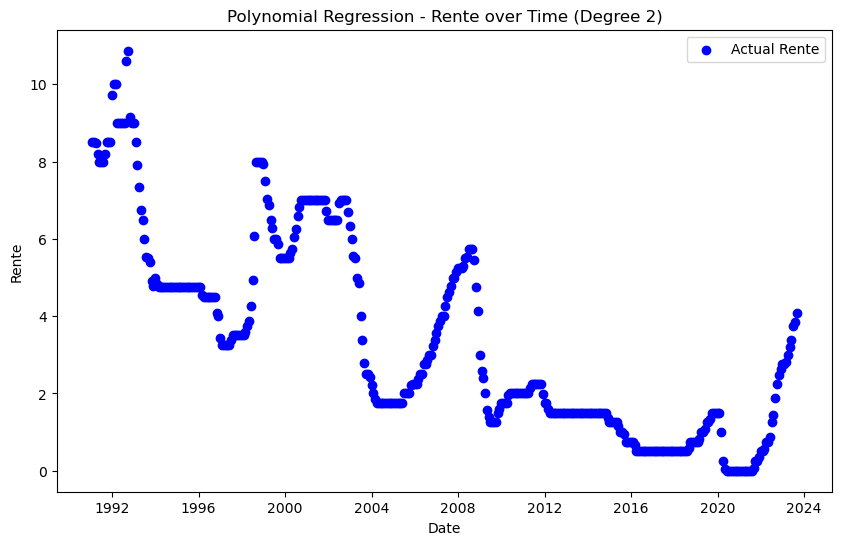

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Assuming you have already loaded and processed your 'rente' DataFrame

# Convert 'Dato' to datetime object
rente['Dato'] = pd.to_datetime(rente['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
rente['Dato_numeric'] = (rente['Dato'] - rente['Dato'].min()).dt.days

# Define the features and the target variable
X_rente = rente[['Dato_numeric']]
y_rente = rente['Rente']

# Initialize the Polynomial Regression model with degree 2
poly = PolynomialFeatures(degree=4)
X_poly_rente = poly.fit_transform(X_rente)

# Fit the Polynomial Regression model
model_poly_rente = LinearRegression()
model_poly_rente.fit(X_poly_rente, y_rente)

# Make predictions
predictions_poly_rente = model_poly_rente.predict(X_poly_rente)

# Visualize the polynomial regression curve and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(rente['Dato'], y_rente, color='blue', label='Actual Rente')

# Plotting the polynomial regression curve
# plt.plot(rente['Dato'], predictions_poly_rente, color='red', label='Polynomial Regression')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Rente')
plt.title('Polynomial Regression - Rente over Time (Degree 2)')
plt.legend()
plt.show()


C:\Users\even\AppData\Local\Temp\ipykernel_16544\1638661773.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rente['Dato'] = pd.to_datetime(rente['Dato'])
C:\Users\even\AppData\Local\Temp\ipykernel_16544\1638661773.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rente['Dato_numeric'] = (rente['Dato'] - rente['Dato'].min()).dt.days
c:\Users\even\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  wa

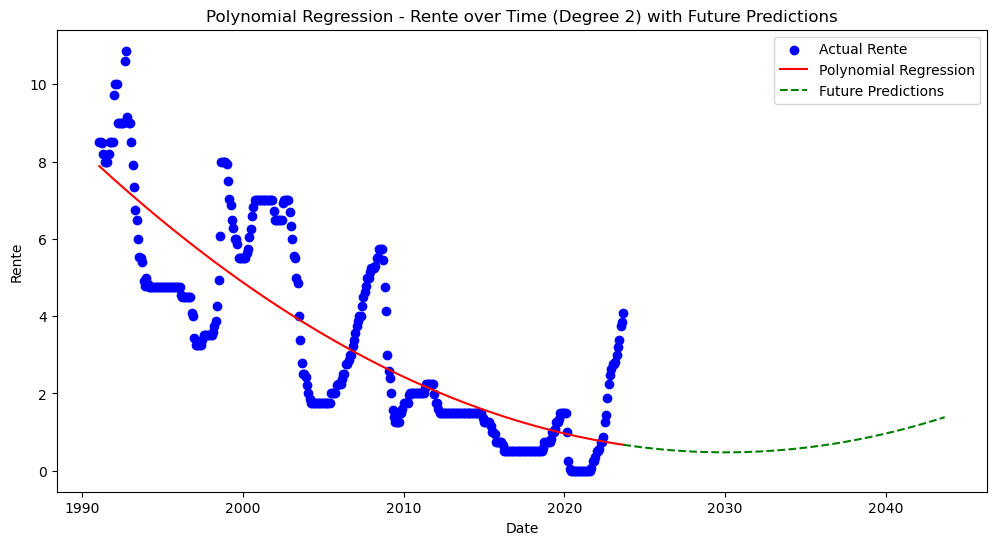

In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Assuming you have already loaded and processed your 'rente' DataFrame

# Convert 'Dato' to datetime object
rente['Dato'] = pd.to_datetime(rente['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
rente['Dato_numeric'] = (rente['Dato'] - rente['Dato'].min()).dt.days

# Define the features and the target variable
X_rente = rente[['Dato_numeric']]
y_rente = rente['Rente']

# Initialize the Polynomial Regression model with degree 2
poly = PolynomialFeatures(degree=2)
X_poly_rente = poly.fit_transform(X_rente)

# Fit the Polynomial Regression model
model_poly_rente = LinearRegression()
model_poly_rente.fit(X_poly_rente, y_rente)

# Generate future dates for the next 20 years
future_dates = pd.date_range(start=rente['Dato'].max(), periods=365*20, freq='D')

# Extract numeric representation of future dates
future_dates_numeric = (future_dates - rente['Dato'].min()).days.values.reshape(-1, 1)

# Transform future dates to polynomial features
future_dates_poly = poly.transform(future_dates_numeric)

# Make predictions for future dates
future_predictions = model_poly_rente.predict(future_dates_poly)

# Visualize the polynomial regression curve and future predictions
plt.figure(figsize=(12, 6))

# Plotting the original data
plt.scatter(rente['Dato'], y_rente, color='blue', label='Actual Rente')

# Plotting the polynomial regression curve
plt.plot(rente['Dato'], model_poly_rente.predict(X_poly_rente), color='red', label='Polynomial Regression')

# Plotting the future predictions
plt.plot(future_dates, future_predictions, color='green', linestyle='dashed', label='Future Predictions')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Rente')
plt.title('Polynomial Regression - Rente over Time (Degree 2) with Future Predictions')
plt.legend()
plt.show()


C:\Users\even\AppData\Local\Temp\ipykernel_16544\1088633912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rente['Dato'] = pd.to_datetime(rente['Dato'])
C:\Users\even\AppData\Local\Temp\ipykernel_16544\1088633912.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rente['Dato_numeric'] = (rente['Dato'] - rente['Dato'].min()).dt.days


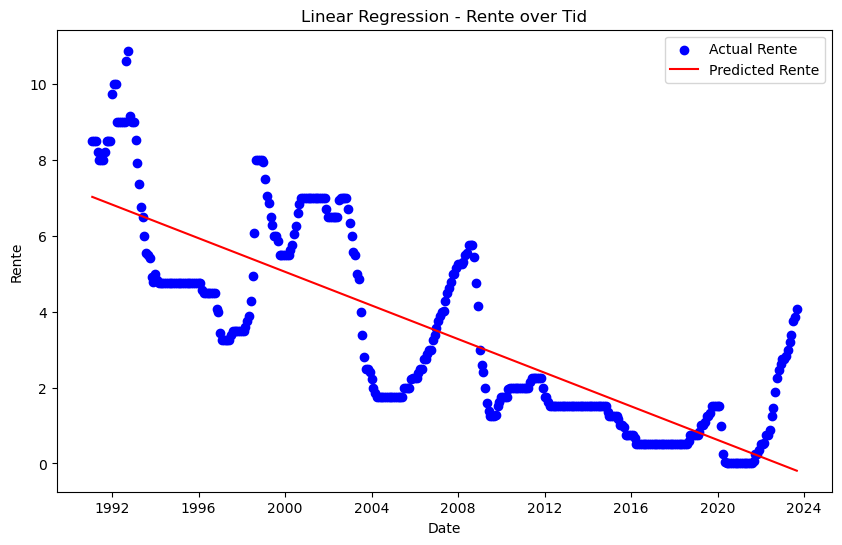

In [17]:
# Convert 'Dato' to datetime object
rente['Dato'] = pd.to_datetime(rente['Dato'])

# Extract numeric representation of 'Dato' (number of days since a specific date) to use in regression
rente['Dato_numeric'] = (rente['Dato'] - rente['Dato'].min()).dt.days

# Define the features and the target variable
X_rente = rente[['Dato_numeric']]
y_rente = rente['Rente']

# Initialize the Linear Regression model
model_rente = LinearRegression()

# Fit the model
model_rente.fit(X_rente, y_rente)

# Make predictions
predictions_rente = model_rente.predict(X_rente)

# Visualize the linear regression line and data
plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(rente['Dato'], y_rente, color='blue', label='Actual Rente')

# Plotting the regression line
plt.plot(rente['Dato'], predictions_rente, color='red', label='Predicted Rente')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Rente')
plt.title('Linear Regression - Rente over Tid')
plt.legend()
plt.show()


Inflasjon (KPI) i prosent og verdi

Fikk ikke inn 2,% % årlig økning

C:\Users\even\AppData\Local\Temp\ipykernel_16544\1615209690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kpi['Dato'] = pd.to_datetime(kpi['Dato'])
C:\Users\even\AppData\Local\Temp\ipykernel_16544\1615209690.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kpi['Dato_numeric'] = (kpi['Dato'] - kpi['Dato'].min()).dt.days


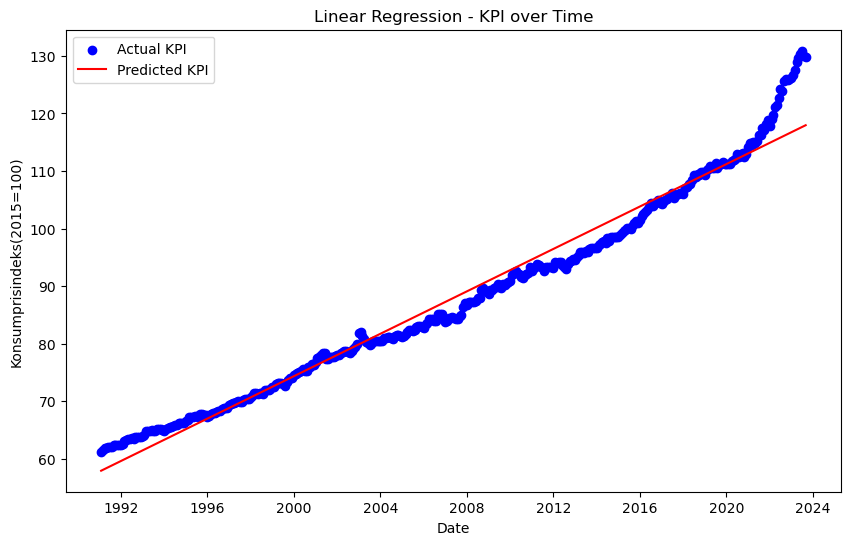

Slope: 0.005044739108759912


In [18]:
# Convert 'Dato' to datetime object
kpi['Dato'] = pd.to_datetime(kpi['Dato'])

kpi['Dato_numeric'] = (kpi['Dato'] - kpi['Dato'].min()).dt.days

X_kpi = kpi[['Dato_numeric']]
y_kpi = kpi['Konsumprisindeks(2015=100)']

model_kpi_r = LinearRegression()
model_kpi_r.fit(X_kpi, y_kpi)

predictions_kpi = model_kpi_r.predict(X_kpi)

# Extract the first Y value and corresponding date
start_date = kpi['Dato'].min()
start_y_value = y_kpi.iloc[0]

# Calculate the slope for a 2.5% yearly increase
slope =  0.025  # 2.5% as a decimal

# Calculate the intercept based on the start point
intercept = start_y_value - slope * (kpi['Dato'] - start_date).dt.days.iloc[0]

plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(kpi['Dato'], y_kpi, color='blue', label='Actual KPI')

# Plotting the regression line
plt.plot(kpi['Dato'], predictions_kpi, color='red', label='Predicted KPI')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Konsumprisindeks(2015=100)')
plt.title('Linear Regression - KPI over Time')
plt.legend()
plt.show()

# Get the slope (coefficient) of the regression line
slope = model_kpi_r.coef_[0]
print("Slope:", slope)

C:\Users\even\AppData\Local\Temp\ipykernel_16544\2114539605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kpi['Dato'] = pd.to_datetime(kpi['Dato'])
C:\Users\even\AppData\Local\Temp\ipykernel_16544\2114539605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kpi['Dato_numeric'] = (kpi['Dato'] - kpi['Dato'].min()).dt.days


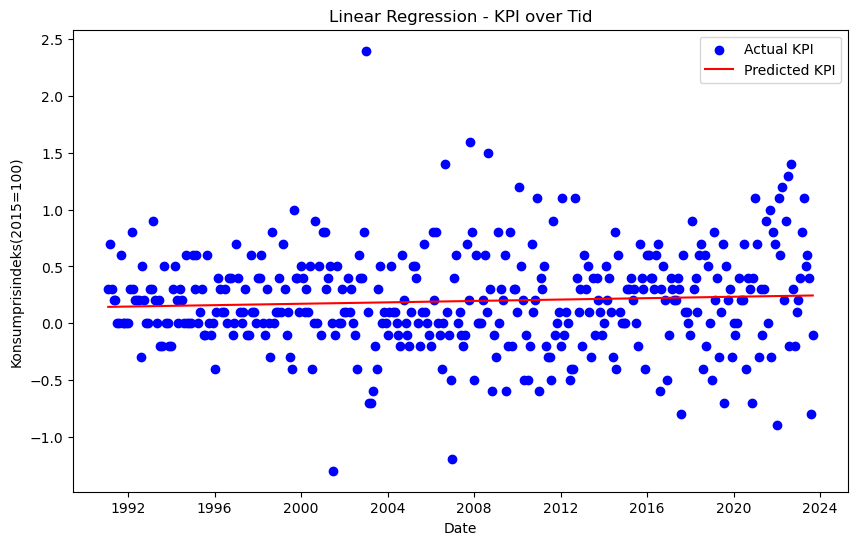

In [19]:
# Convert 'Dato' to datetime object
kpi['Dato'] = pd.to_datetime(kpi['Dato'])

kpi['Dato_numeric'] = (kpi['Dato'] - kpi['Dato'].min()).dt.days

X_kpi = kpi[['Dato_numeric']]
y_kpi = kpi['Månedsendring (prosent)']

model_kpi = LinearRegression()
model_kpi.fit(X_kpi, y_kpi)

predictions_kpi = model_kpi.predict(X_kpi)

plt.figure(figsize=(10, 6))

# Plotting the data
plt.scatter(kpi['Dato'], y_kpi, color='blue', label='Actual KPI')
# Plotting the regression line
plt.plot(kpi['Dato'], predictions_kpi, color='red', label='Predicted KPI')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Konsumprisindeks(2015=100)')
plt.title('Linear Regression - KPI over Tid')
plt.legend()
plt.show()

BNP

The slope of the linear regression model is: 15458.456501323311


c:\Users\even\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Year
Feature names seen at fit time, yet now missing:
- År

  warnings.warn(message, FutureWarning)


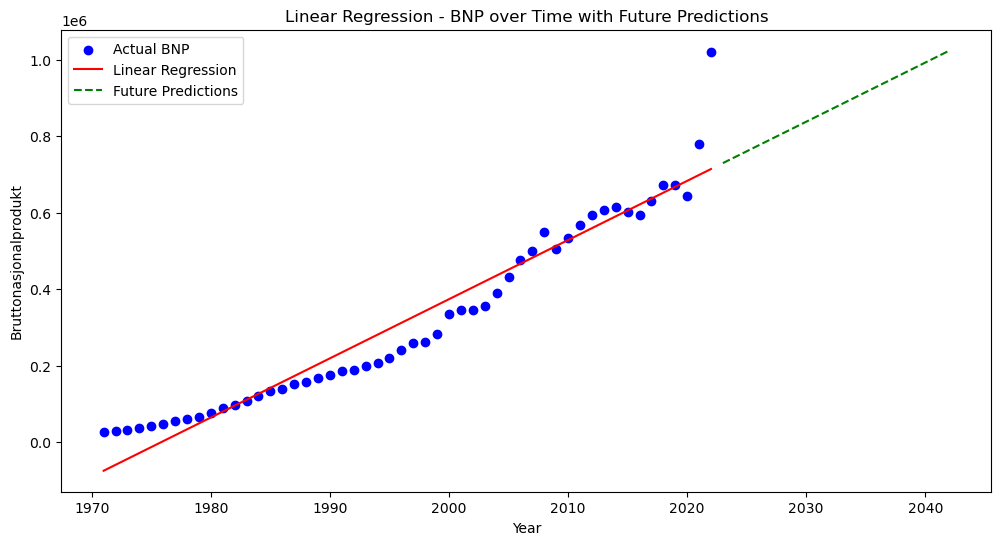

In [20]:
# Linear Regression
X_bnp = bnp[['År']]
y_bnp = bnp['Bruttonasjonalprodukt']

# Initialize the Linear Regression model
model_bnp_r = LinearRegression()
model_bnp_r.fit(X_bnp, y_bnp)

# Get the slope of the linear regression model
slope_bnp = model_bnp_r.coef_[0]
print(f"The slope of the linear regression model is: {slope_bnp}")

# Create a DataFrame for future yearly predictions
future_years = pd.Series(range(bnp['År'].max() + 1, bnp['År'].max() + 21))
predicted_bnp = pd.DataFrame({'Year': future_years})

# Add a new column for predicted BNP using the linear regression model
predicted_bnp['Predicted_BNP'] = model_bnp_r.predict(predicted_bnp[['Year']])

# Plotting
plt.figure(figsize=(12, 6))

# Plotting the actual data
plt.scatter(bnp['År'], y_bnp, color='blue', label='Actual BNP')

# Plotting the linear regression line
plt.plot(bnp['År'], model_bnp_r.predict(X_bnp), color='red', label='Linear Regression')

# Plotting the future predictions
plt.plot(predicted_bnp['Year'], predicted_bnp['Predicted_BNP'], color='green', linestyle='dashed', label='Future Predictions')

# Labels and title
plt.xlabel('Year')
plt.ylabel('Bruttonasjonalprodukt')
plt.title('Linear Regression - BNP over Time with Future Predictions')
plt.legend()
plt.show()


In [21]:
# Get the last observed value from the original dataset
last_observed_value = y_bnp.iloc[-1]

# Get the last predicted value from the regression model
last_predicted_value = model_bnp_r.predict(X_bnp.iloc[[-1]])[0]

# Calculate the difference between the last observed and predicted values
difference = last_observed_value - last_predicted_value

# Calculate the difference percentage
difference_percentage = (difference / last_predicted_value) * 100

print(f"The difference between the last observed and predicted values is: {difference}")
print(f"The difference percentage is: {difference_percentage:.2f}%")

The difference between the last observed and predicted values is: 306514.6284470223
The difference percentage is: 42.91%


FEIL HER

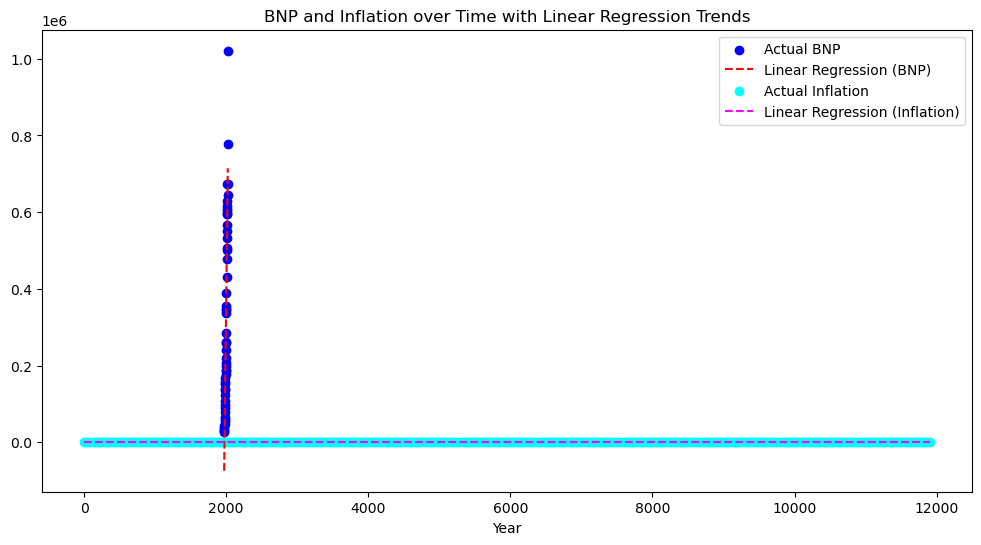

In [22]:
# Create a figure
plt.figure(figsize=(12, 6))

# Plotting the actual BNP data
plt.scatter(bnp['År'], y_bnp, color='blue', label='Actual BNP')

# Plotting the linear regression line for BNP
plt.plot(bnp['År'], model_bnp_r.predict(X_bnp), color='red', linestyle='dashed', label='Linear Regression (BNP)')

# Plotting the actual Inflation data
plt.scatter(kpi['Dato_numeric'], y_kpi, color='cyan', label='Actual Inflation')

# Plotting the linear regression line for Inflation
plt.plot(kpi['Dato_numeric'], model_kpi_r.predict(X_kpi), color='magenta', linestyle='dashed', label='Linear Regression (Inflation)')

# Labels and title
plt.xlabel('Year')
plt.title('BNP and Inflation over Time with Linear Regression Trends')

# Show the legend
plt.legend()
plt.show()

ALLE variablene i df_rente_kpi

In [23]:
df_rente_kpi['Dato'] = pd.to_datetime(df_rente_kpi['Dato'])
df_rente_kpi['Dato_numeric'] = (df_rente_kpi['Dato'] - df_rente_kpi['Dato'].min()).dt.days

X = df_rente_kpi[['Dato_numeric', 'Konsumprisindeks(2015=100)', 'Månedsendring (prosent)']]
y = df_rente_kpi['Rente']

model_total = LinearRegression()
model_total.fit(X,y)

predictions_total = model_total.predict(X)

df_rente_kpi['Predicted Rente'] = predictions_total

from sklearn.metrics import mean_squared_error, r2_score

print('R-squared:', r2_score(y, predictions_total))
print('Mean Squared Error:', mean_squared_error(y, predictions_total))

R-squared: 0.7237735089671995
Mean Squared Error: 1.8413651090402954


Vi ser at for tid & kpi i % er dårlige mål

Problem med regressjon

In [24]:
# Get the maximum 'Dato_numeric' value in the original dataframe
max_date = df_rente_kpi['Dato_numeric'].max()

# Create a new dataframe with 'Dato_numeric' representing 15 years into the future
future_df = pd.DataFrame({
    'Dato_numeric': [max_date + 365*15]  # Add 15 years (365 days per year)
})


In [25]:
# Use the model to predict the rente in 15 years
future_rente = model_rente.predict(future_df)

print("The predicted rente in 15 years is:", future_rente[0])


The predicted rente in 15 years is: -3.509762505656793


Koeffisientene til regressjonsmodellen

In [26]:
# Get the coefficients of the model
coefficients = model_rente.coef_

# Print the coefficients with their meanings
for i, coef in enumerate(coefficients):
    print(f"The coefficient for 'Dato_numeric' is {coef}. It represents the average rate of change in 'Rente' for each additional day, assuming all other variables are held constant.")

The coefficient for 'Dato_numeric' is -0.0006060712809893146. It represents the average rate of change in 'Rente' for each additional day, assuming all other variables are held constant.


https://stats.stackexchange.com/questions/219579/what-is-wrong-with-extrapolation

Inntekt de neste 25 årene - første 2 årene etter regression line, også etter 2 år, så hopper til 50 000 kr i måend

In [27]:
t1 = 25

In [28]:
# Define time for 25 periods (years)
future_time = np.array(range(1, t1 + 1)).reshape(-1, 1)  # Creating an array from 1 to 25 for future time

c:\Users\even\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


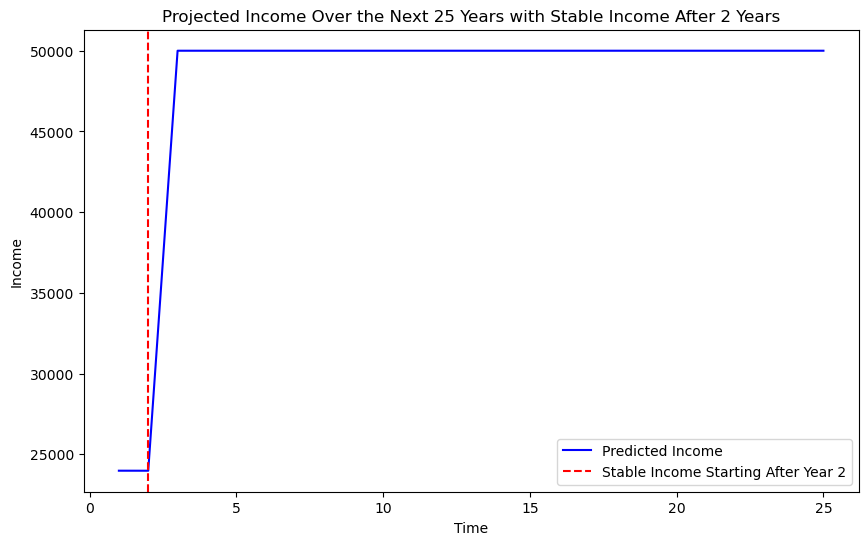

In [29]:
# Predicting income for the next 25 years using the model
predicted_income_future = model_inntekt.predict(future_time)

# Modify the predicted income values after the second year
change_index = 2  # Index for the third year
stable_income = 50000  # Stable income value

# Apply the change in income prediction
predicted_income_future[change_index:] = stable_income

# Plotting the future predictions with adjusted income after the second year
plt.figure(figsize=(10, 6))
plt.plot(future_time, predicted_income_future, color='blue', label='Predicted Income')

plt.xlabel('Time')
plt.ylabel('Income')
plt.title('Projected Income Over the Next 25 Years with Stable Income After 2 Years')
plt.axvline(x=2, color='red', linestyle='--', label='Stable Income Starting After Year 2')
plt.legend()
plt.show()

Faste utgifter - de neste 25 årene

c:\Users\even\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


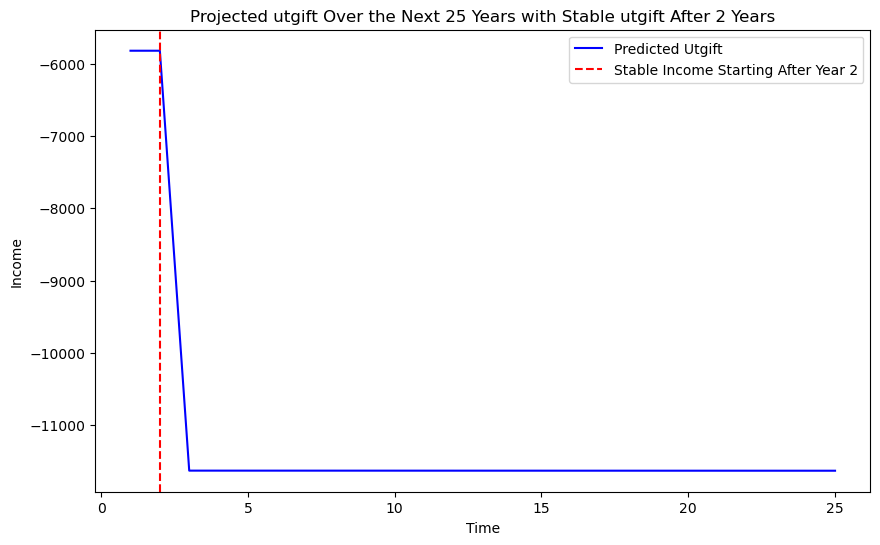

In [30]:
# Predicting income for the next 25 years using the model
predicted_utgift_future = model_utgift.predict(future_time)

# Modify the predicted income values after the second year
change_index = 2  # Index for the third year
change_factor = 2  # Adjust income by a factor of 1.2 (120%)

# Apply the change in income prediction
predicted_utgift_future[change_index:] *= change_factor

# Plotting the future predictions with adjusted income after the second year
plt.figure(figsize=(10, 6))
plt.plot(future_time, predicted_utgift_future, color='blue', label='Predicted Utgift')

plt.xlabel('Time')
plt.ylabel('Income')
plt.title('Projected utgift Over the Next 25 Years with Stable utgift After 2 Years')
plt.axvline(x=2, color='red', linestyle='--', label='Stable Income Starting After Year 2')
plt.legend()
plt.show()

Forbruk - de neste 25 årene

c:\Users\even\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


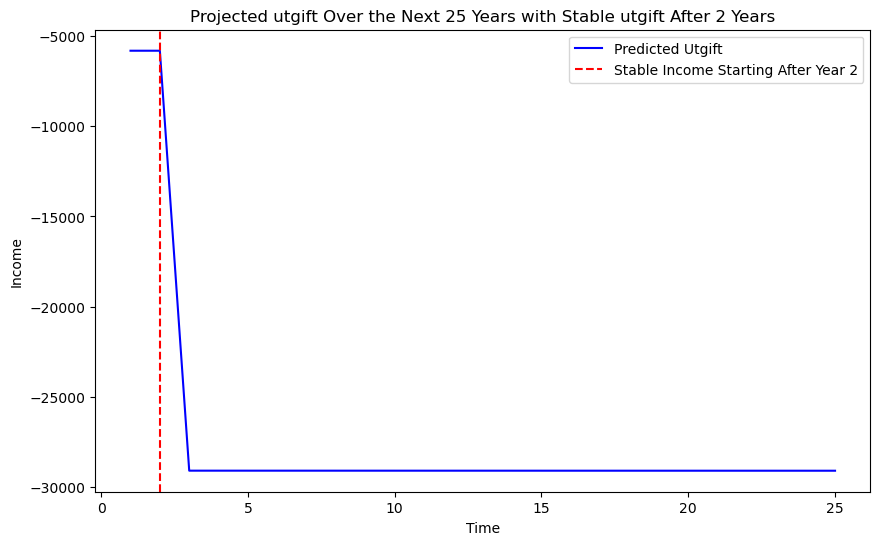

In [31]:
# Predicting income for the next 25 years using the model
predicted_forbruk_future = model_forbruk.predict(future_time)

# Modify the predicted income values after the second year
change_index = 2  # Index for the third year
change_factor = 2.5  # Adjust income by a factor of 1.2 (120%)

# Apply the change in income prediction
predicted_utgift_future[change_index:] *= change_factor

# Plotting the future predictions with adjusted income after the second year
plt.figure(figsize=(10, 6))
plt.plot(future_time, predicted_utgift_future, color='blue', label='Predicted Utgift')

plt.xlabel('Time')
plt.ylabel('Income')
plt.title('Projected utgift Over the Next 25 Years with Stable utgift After 2 Years')
plt.axvline(x=2, color='red', linestyle='--', label='Stable Income Starting After Year 2')
plt.legend()
plt.show()

RENTE ODE

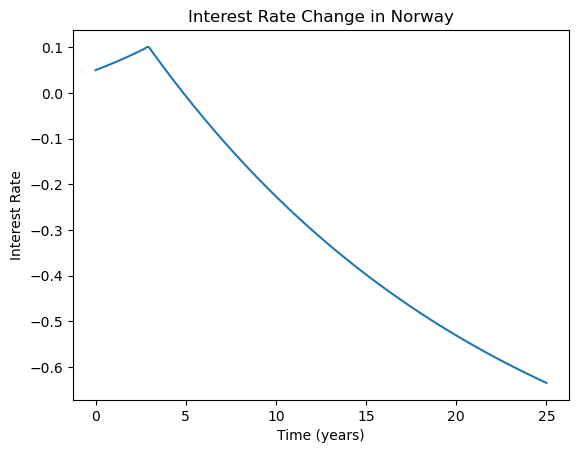

In [32]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the ODE function
def interest_rate_ode(t, r, k1, k2, b1, b2, t_switch):
    if t < t_switch:
        drdt = k1 * r + b1
    else:
        drdt = -k2 * r - b2
    return drdt

# Set initial conditions
initial_interest_rate = 0.05  # initial interest rate
decay_constant1 = 0.1  # decay constant before switch
decay_constant2 = 0.05  # decay constant after switch
external_influence1 = 0.01  # external influence before switch
external_influence2 = 0.05  # external influence after switch
switch_time = 3  # time to switch from the first regime to the second (in years)

# Set time points for the solution
t_span = (0, 25)  # solve from t=0 to t=25 years
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solve the ODE
solution = solve_ivp(
    interest_rate_ode,
    t_span,
    [initial_interest_rate],
    args=(decay_constant1, decay_constant2, external_influence1, external_influence2, switch_time),
    t_eval=t_eval
)

# Plot the results
plt.plot(solution.t, solution.y[0])
plt.title('Interest Rate Change in Norway')
plt.xlabel('Time (years)')
plt.ylabel('Interest Rate')
plt.show()

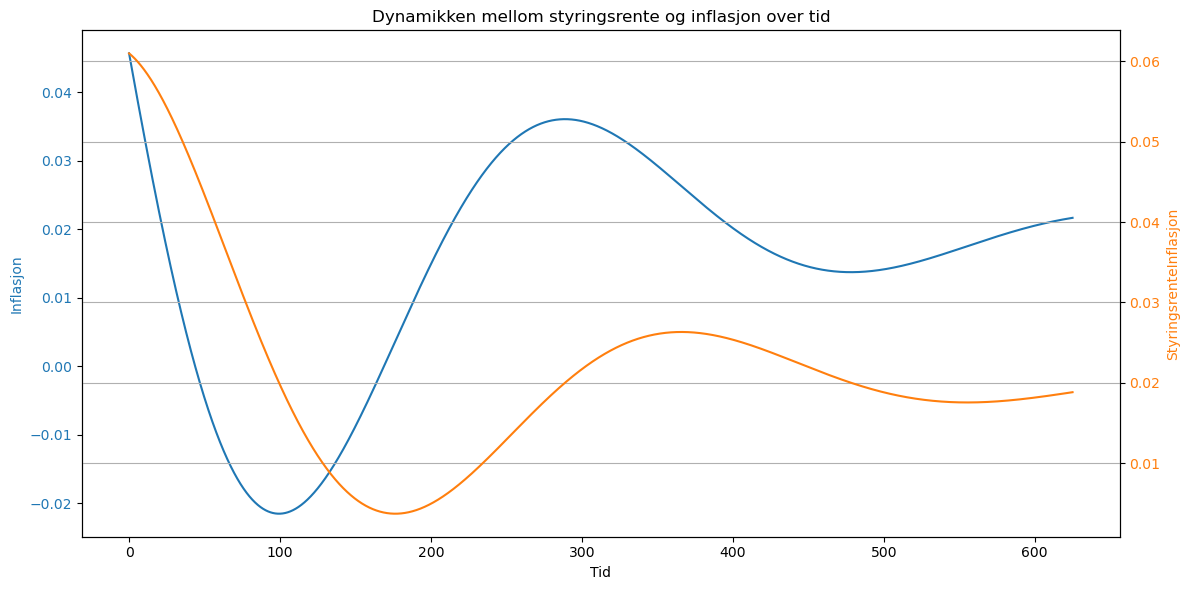

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parametere
gamma = 0.03  # hvor raskt styringsrenten justeres
delta = 0.01  # hvor raskt inflasjonen justeres
i_target = 0.02  # inflasjonsmålet

# Differensialligninger
def model(y, t):
    i, r = y
    di_dt = delta * (r - i)
    dr_dt = gamma * (i_target - i)
    return [di_dt, dr_dt]

# Initialbetingelser
i0 = 0.061  # initial inflasjon
r0 = 0.0457  # initial styringsrente
y0 = [i0, r0]

# Tidsintervaller
t = np.linspace(0, 25*25, 100000)

# Løse ODE-systemet
solution = odeint(model, y0, t)

# Opprette figur og akser
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotte styringsrente
color = 'tab:blue'
ax1.set_xlabel('Tid')
ax1.set_ylabel('Inflasjon', color=color)
ax1.plot(t, solution[:, 1], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Opprette en annen y-akse for inflasjon
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('StyringsrenteInflasjon', color=color)
ax2.plot(t, solution[:, 0], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Tittel og grid
plt.title('Dynamikken mellom styringsrente og inflasjon over tid')
fig.tight_layout()
plt.grid(True)
plt.show()

FORBRUK ODE

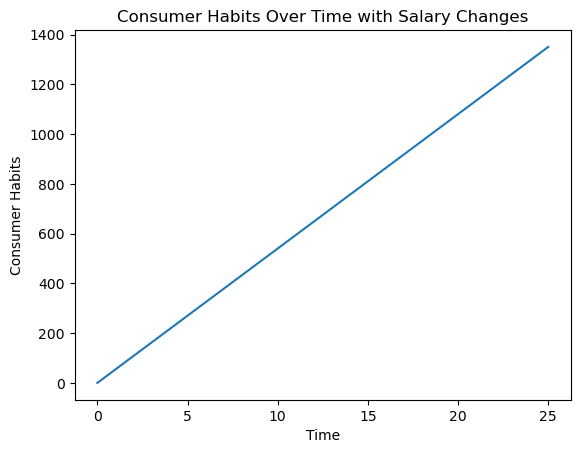

In [34]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the ODE function
def consumer_habits_ode(t, h, alpha, k1, k2, income, expenses):
    dhdrdt = alpha * (income(t) - expenses(t)) + k1 * income(t) - k2 * expenses(t)
    return dhdrdt

# Set initial conditions
initial_habits = 0.5  # initial consumer habits
alpha = 0.1  # constant determining the effect of income and expenses
k1 = 0.05  # parameter for the effect of salary increase
k2 = 0.02  # parameter for the effect of salary decrease

# Define functions for income and expenses over time
def income(t):
    return np.linspace(1000, 1200, 1)  # return a scalar value

def expenses(t):
    return np.linspace(800, 900, 1)  # return a scalar value

# Set time points for the solution
t_span = (0, 25)  # solve from t=0 to t=25
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Solve the ODE
solution = solve_ivp(consumer_habits_ode, t_span, [initial_habits], args=(alpha, k1, k2, income, expenses), t_eval=t_eval)

# Plot the results
plt.plot(solution.t, solution.y[0])
plt.title('Consumer Habits Over Time with Salary Changes')
plt.xlabel('Time')
plt.ylabel('Consumer Habits')
plt.show()

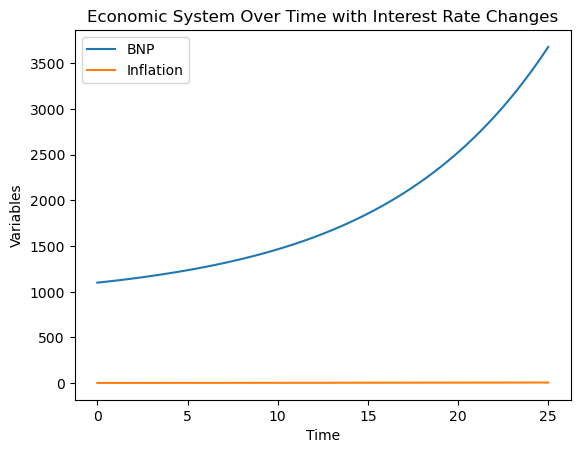

In [35]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the ODE function
def economic_system_ode(t, variables, alpha_bnp, k1_bnp, k2_bnp, alpha_inf, k1_inf, k2_inf, interest_rate):
    bnp, inflation = variables
    dbnpdt = alpha_bnp * (bnp - bnp_trend(t)) + k1_bnp * bnp - k2_bnp * bnp * interest_rate
    dinfdt = alpha_inf * (inflation - inflation_trend(t)) + k1_inf * inflation - k2_inf * inflation * interest_rate
    return [dbnpdt, dinfdt]

# Define BNP and inflation trends over time
def bnp_trend(t):
    # Define the trend function here, for example:
    return 1000 + 2 * t

def inflation_trend(t):
    # Define the trend function here, for example:
    return 2 + 0.1 * t

# Set initial conditions
initial_bnp = 1100  # initial BNP
initial_inflation = 3  # initial inflation

# Set parameters for the system
alpha_bnp = 0.1
k1_bnp = 0.01
k2_bnp = 0.001
alpha_inf = 0.05
k1_inf = 0.02
k2_inf = 0.002

# Set time points for the solution
t_span = (0, 25)  # solve from t=0 to t=25
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Set interest rate (you can adjust this based on your requirements)
interest_rate = 0.1

# Solve the ODE
solution = solve_ivp(economic_system_ode, t_span, [initial_bnp, initial_inflation], 
                      args=(alpha_bnp, k1_bnp, k2_bnp, alpha_inf, k1_inf, k2_inf, interest_rate),
                      t_eval=t_eval)

# Plot the results
plt.plot(solution.t, solution.y[0], label='BNP')
plt.plot(solution.t, solution.y[1], label='Inflation')
plt.title('Economic System Over Time with Interest Rate Changes')
plt.xlabel('Time')
plt.ylabel('Variables')
plt.legend()
plt.show()


## TOTAL LØSNING

Initialisering

In [36]:
I0 = predictions_inntekt[-1]                # Startinntekt pr måend
U0 = predictions_utgift[-1]                 # Faste utgifter
R0 = df_rente_kpi['Rente'].iloc[-1] +0.5    # Startboliglånsrente
F0 = predictions_forbruk[-1]                # Initiale forbruksvaner
S0 = I0 - U0 - F0

In [37]:
k1 = 0.8        # Økning i forbruk etter inntekt                    -> hurtig økning etter inntektsøkning
k2 = 0.7        # Reduksjon i forbruk etter inntekt                 -> sakte endring etter inntektsfall
k3 = 0.3        # Renteendring basert på forbruk                    -> Forbruk øker -> Renter øker  -> Lånet påvirkes -> Må bruke mindre penger
k4 = 0.025      # Endring i inflasjon basert på forbuk & rente      -> Endres 0,25 poeng oftest

In [38]:
# Initial conditions
y0 = [I0, U0, R0, F0, S0]

In [39]:
# Time points
t0 = 0
t1 = 365 * 25

# Definer tidsintervall og initialverdier
t = np.linspace(t0, t1, 1000)

ODE - Rente

In [40]:
def dI_dt(I, t):
    return 0

In [41]:
def dFa_dt(F, t):
    return 0

In [42]:
# Function to represent dA/dt (change in surplus)
def dA_dt(A, t):
    return 0

In [43]:
def calculate_effective_rate(r_nom, n):
    return (1 + r_nom / n) ** n - 1

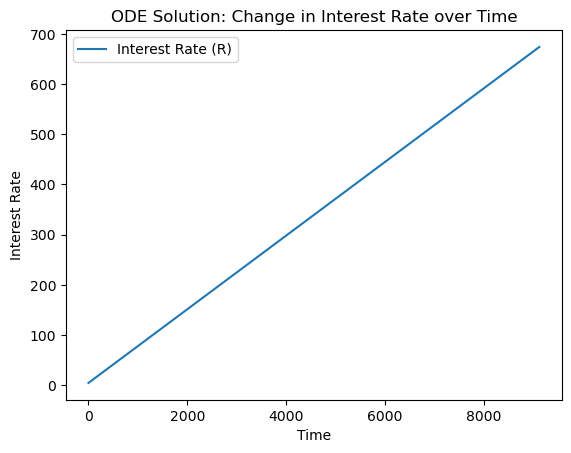

In [44]:
# Function to represent the ODE
def dR_dt(R, t):
    r_nom = 0.0521  # Nominal interest rate
    n = 12  # Assuming monthly compounding
    r_eff = calculate_effective_rate(r_nom, n)
    return r_eff + 0.02

# Solve the ODE
solution = odeint(dR_dt, R0, t)

plt.plot(t, solution, label='Interest Rate (R)')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.title('ODE Solution: Change in Interest Rate over Time')
plt.legend()
plt.show()


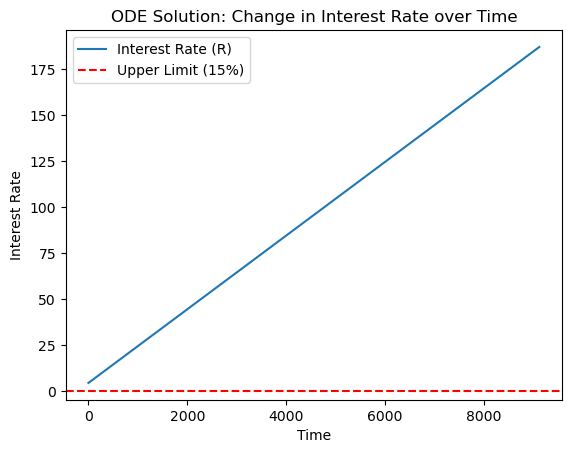

In [45]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Function to represent the ODE
def dR_dt(R, t, r_nom):
    n = 12  # Assuming monthly compounding
    r_eff = calculate_effective_rate(r_nom, n)
    return r_eff + 0.02

# Objective function to minimize
def objective(params, t_points, initial_R):
    r_nom = params[0]
    solution = odeint(dR_dt, initial_R, t_points, args=(r_nom,))
    return np.sum(np.maximum(0, solution - 0.15)**2)  # Penalty for exceeding 15%

# Perform optimization to find the nominal interest rate
result = minimize(objective, x0=[0.05], args=(t, R0), bounds=[(0, 0.15)])

# Extract the optimal nominal interest rate
optimal_r_nom = result.x[0]

# Solve the ODE with the optimal nominal interest rate
solution = odeint(dR_dt, R0, t, args=(optimal_r_nom,))

# Plot the solution
plt.plot(t, solution, label='Interest Rate (R)')
plt.axhline(0.15, color='red', linestyle='--', label='Upper Limit (15%)')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.title('ODE Solution: Change in Interest Rate over Time')
plt.legend()
plt.show()

In [46]:
def dR_dt(R, t):
    r_nom = 0.0521  # Nominal interest rate
    n = 12  # Assuming monthly compounding
    return calculate_effective_rate(r_nom, n) + 0.02

In [47]:
def dF_dt(C, t, k1):
    return k1 * dR_dt(None, t)

In [48]:
def system(y, t, alpha):
    I, F, R, C, A = y
    dI = dI_dt(I, t)
    dF = dFa_dt(F, t)
    dR = dR_dt(R, t)
    dC = dF_dt(C, t, alpha)
    dA = dA_dt(A, t)
    return [dI, dF, dR, dC, dA]

In [49]:
solution = odeint(system, y0, t, args=(k1,))

In [50]:
I, F, R, C, A = solution.T

print("Rentenivå:", R)
print("Forbruk:", C)
print("Overskudd:", A)

Rentenivå: [  4.57         5.24010097   5.91020193   6.5803029    7.25040387
   7.92050483   8.5906058    9.26070677   9.93080773  10.6009087
  11.27100967  11.94111063  12.6112116   13.28131257  13.95141353
  14.6215145   15.29161547  15.96171643  16.6318174   17.30191837
  17.97201933  18.6421203   19.31222127  19.98232223  20.6524232
  21.32252417  21.99262513  22.6627261   23.33282707  24.00292803
  24.673029    25.34312997  26.01323093  26.6833319   27.35343287
  28.02353383  28.6936348   29.36373577  30.03383673  30.7039377
  31.37403867  32.04413963  32.7142406   33.38434157  34.05444253
  34.7245435   35.39464447  36.06474543  36.7348464   37.40494737
  38.07504833  38.7451493   39.41525027  40.08535123  40.7554522
  41.42555317  42.09565413  42.7657551   43.43585607  44.10595704
  44.776058    45.44615897  46.11625994  46.7863609   47.45646187
  48.12656284  48.7966638   49.46676477  50.13686574  50.8069667
  51.47706767  52.14716864  52.8172696   53.48737057  54.15747154
  54

In [51]:
# Parameters
C0 = 100            # Autonomous consumption
c1 = 0.7            # Marginal propensity to consume
I0 = 50             # Autonomous investment
i1 = -20            # Marginal propensity to invest
G = 30              # Government spending
M = 80              # Money supply
P = 1               # Price level
L0 = 80             # Autonomous money demand
L1 = 0.5            # Sensitivity of money demand to income
L2 = -15            # Sensitivity of money demand to the interest rate
pi_e = 0.025        # Expected inflation rate
alpha = 0.2         # Phillips Curve parameter
Y_star = 100        # Natural level of output
zi = 2              # Exogenous variable in interest rate equation
d1 = 0.6            # Coefficient in interest rate equation
pi_star = 2         # Target inflation rate in interest rate equation
d2 = -0.2           # Coefficient in interest rate equation
Yn = 100            # Potential output in interest rate equation

In [52]:
last_observed_value_bnp = y_bnp.iloc[-1]
last_observed_value_rente = y_rente.iloc[-1]
last_observed_value_inflasjon = y_kpi.iloc[-1]

print (last_observed_value_rente)
print (last_observed_value_inflasjon)
print (last_observed_value_bnp)

4.07
-0.1
1020805


In [53]:
# Define the system of ODEs
def SOE_odes(variables, t):
    Y, r, pi = variables

    # Define the equations
    dY_dt = IS_function(Y, r) - Y
    dr_dt = Phillips_curve(Y, pi_e, alpha, Y_star) - pi
    dpi_dt = LM_function(Y, r) - pi

    return [dY_dt, dr_dt, dpi_dt]

# Define the IS function
def IS_function(Y, r):
    T = 0.2 * Y  # Taxes as 20% of output
    return C0 + c1 * (Y - T) + I0 + i1 * r + G

# Define the Phillips Curve function
def Phillips_curve(Y, pi_e, alpha, Y_star):
    return pi_e - alpha * (Y - Y_star)

# Define the LM function
def LM_function(Y, r):
    return M/P - L0 + L1 * Y - L2 * r

# Set initial conditions
initial_conditions = [last_observed_value_bnp, last_observed_value_rente, last_observed_value_inflasjon]

# Set time points for simulation
t = np.linspace(0, 25, 10000)  # Adjust time range and steps as needed

# Solve the system of ODEs
solution = odeint(SOE_odes, initial_conditions, t)

# Extract the results
Y_values, r_values, pi_values = solution[:, 0], solution[:, 1], solution[:, 2]
s

NameError: name 's' is not defined

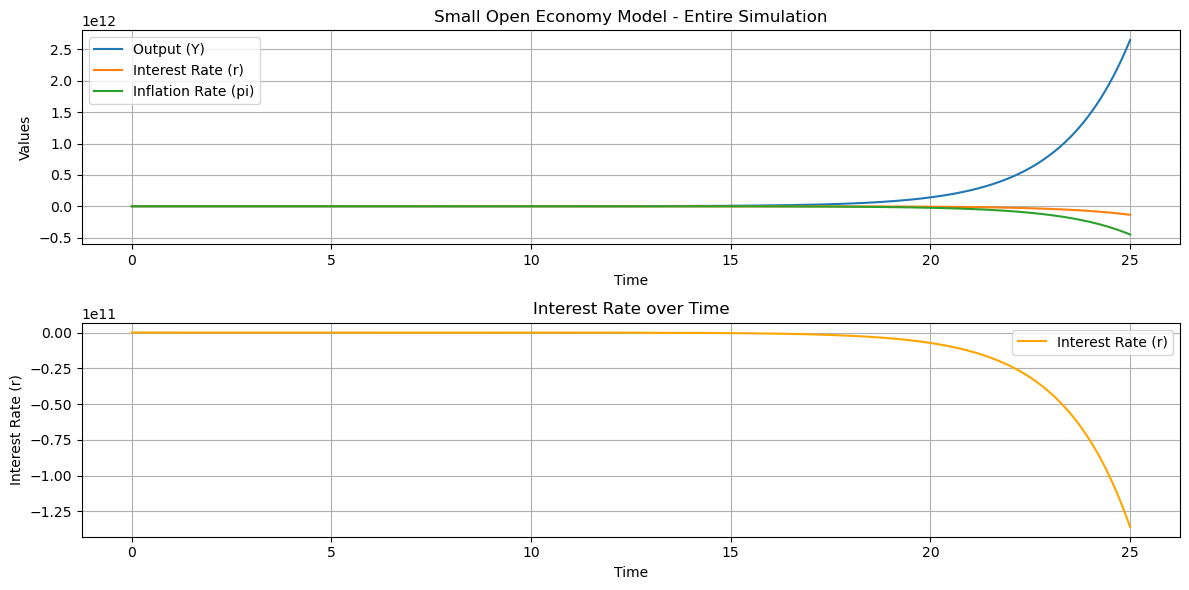

In [ ]:
# Plot the results for the entire simulation
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(t, Y_values, label='Output (Y)')
plt.plot(t, r_values, label='Interest Rate (r)')
plt.plot(t, pi_values, label='Inflation Rate (pi)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Small Open Economy Model - Entire Simulation')
plt.legend()
plt.grid(True)

# Plot the interest rate over the last 25 years
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(t, r_values, color='orange', label='Interest Rate (r)')
plt.xlabel('Time')
plt.ylabel('Interest Rate (r)')
plt.title('Interest Rate over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

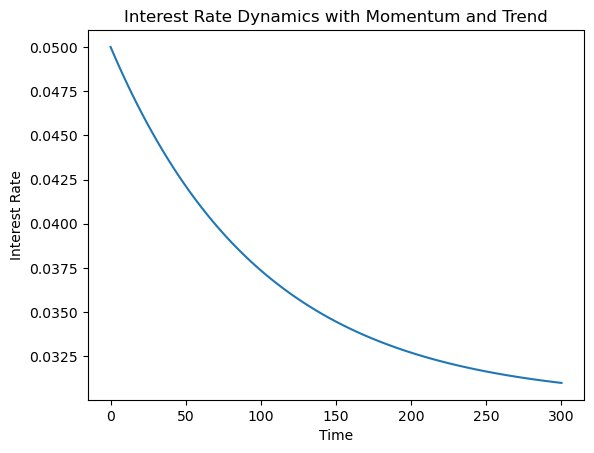

In [ ]:
import numpy as np
from scipy.integrate import odeint

# Define the ODE
def interest_rate_ode(r, t, alpha, beta, model_kpi_r, model_kpi_r_dot):
    drdt = -alpha * (r - model_kpi_r) - beta * model_kpi_r_dot
    return drdt

# Set initial conditions and parameters
initial_rate = 0.05  # Initial interest rate
alpha = 0.01  # Strength of the feedback loop
beta = 0.05  # Strength of the momentum term
model_kpi_r = 0.03  # Predicted interest rate from your regression model
model_kpi_r_dot = 0.0  # Initial rate of change of predicted interest rate

# Set time points for the solution
t = np.linspace(0, 25*12, 100)

# Solve the ODE
solution = odeint(interest_rate_ode, initial_rate, t, args=(alpha, beta, model_kpi_r, model_kpi_r_dot))

# Plot the results
import matplotlib.pyplot as plt
plt.plot(t, solution)
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.title('Interest Rate Dynamics with Momentum and Trend')
plt.show()


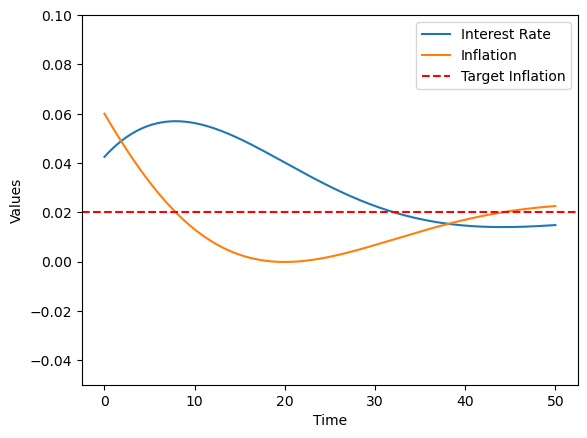

## Ønsket lån

start kapital og lengde

Serielån

In [ ]:
def calculate_serial_loan(principal, annual_interest_rate, loan_term):
    # Convert annual interest rate to monthly
    monthly_interest_rate = annual_interest_rate / 12 / 100

    # Convert loan term to months
    loan_term_months = loan_term * 12

    # Calculate the monthly payment
    monthly_payment = principal * (monthly_interest_rate * (1 + monthly_interest_rate) ** loan_term_months) / ((1 + monthly_interest_rate) ** loan_term_months - 1)

    return monthly_payment

Annuitetslån

In [ ]:
def calculate_annual_loan(principal, annual_interest_rate, loan_term):
    # Convert annual interest rate to decimal
    annual_interest_rate_decimal = annual_interest_rate / 100

    # Calculate the annual payment
    annual_payment = principal * (annual_interest_rate_decimal * (1 + annual_interest_rate_decimal) ** loan_term) / ((1 + annual_interest_rate_decimal) ** loan_term - 1)

    return annual_payment

In [ ]:
# Example usage:
pris = 3000000
ek = 0
lan = pris-ek
annual_interest_rate = 7  # Annual interest rate (%)
loan_term = 25  # Loan term in years

In [ ]:
annual_payment = calculate_annual_loan(lan, annual_interest_rate, loan_term)
print(f"The annual payment for an annual loan of {lan} with an annual interest rate of {annual_interest_rate}% for a term of {loan_term} years is {annual_payment:.2f}.")

The annual payment for an annual loan of 3000000 with an annual interest rate of 7% for a term of 25 years is 257431.55.


In [ ]:
monthly_payment = calculate_serial_loan(lan, annual_interest_rate, loan_term)

print(f"The monthly payment for a serial loan of {lan} with an annual interest rate of {annual_interest_rate}% for a term of {loan_term} years is {monthly_payment:.2f}.")

The monthly payment for a serial loan of 3000000 with an annual interest rate of 7% for a term of 25 years is 21203.38.
